In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import PowerTransformer
yj = PowerTransformer(method='yeo-johnson')


def yj_transform_train_test(df_train_before, df_test_before):
    yj_model = yj.fit(df_train_before.drop(['id', 'label'], axis=1))
    
    df_train_after = yj_transform_by_model(yj_model, df_train_before)
    df_test_after = yj_transform_by_model(yj_model, df_test_before)
    
    return df_train_after, df_test_after

def yj_transform_by_model(yj_model, df_data_before):
    list_pid = list(df_data_before['id']).copy()
    list_label = list(df_data_before['label']).copy()
    
    df_data_before = df_data_before.drop(['id', 'label'], axis=1)
    
    X_data_after = yj_model.transform(df_data_before)
    df_data_after = pd.DataFrame(X_data_after)
    df_data_after.columns = df_data_before.columns
    df_data_after['id'] = list_pid
    df_data_after['label'] = list_label
    
    return df_data_after

def get_feature_and_label(df_data, var_label):
    X = df_data.drop([var_label, 'id'], axis = 1)
    y = df_data[var_label]
    
    return X, y

def get_roc_curve(y_pred_prob, y):
    fpr, tpr, _ = roc_curve(y, y_pred_prob[:,1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic xgb')
    plt.legend(loc="lower right")
    plt.show()
    
BASE_PATH = './data/malignancy_extracted_feature/'
PATH_feature_all = BASE_PATH + 'thyroid_feature_all.csv'
PATH_feature_test = BASE_PATH + 'thyroid_feature_198.csv'

# XGBoost classifier

In [21]:
# Load malignancy feature data
df_feature_all = pd.read_csv(PATH_feature_all)
df_feature_test = pd.read_csv(PATH_feature_test)
id_train = set(df_feature_all['id']) - set(df_feature_test['id'])
id_test = list(df_feature_test['id'])
df_feature_train = pd.DataFrame({'id': list(id_train)})
df_feature_train = df_feature_train.merge(df_feature_all, how='left')

# Train-validation split
df_feature_train, df_feature_val = train_test_split(df_feature_train, test_size=0.2)

var_label = 'label'
X_train, y_train = get_feature_and_label(df_feature_train, var_label)
X_val, y_val = get_feature_and_label(df_feature_val, var_label)
X_test, y_test = get_feature_and_label(df_feature_test, var_label)

print('label imbalance: ', sum(y_train==1)/sum(y_train==0))

label imbalance:  0.5520833333333334


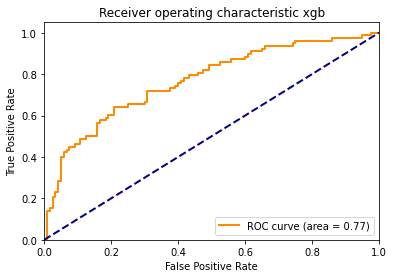

In [20]:
eval_set  = [(X_train,y_train), (X_val,y_val)]
classifier_xgb = XGBClassifier(
    n_estimators=5000,
    scale_pos_weight = 1.82,
    eta = 0.1,  
    max_depth = 2,
).fit(
    X_train, 
    y_train, 
    eval_set=eval_set,
    eval_metric="auc", 
    early_stopping_rounds=10, 
    verbose=0
)

y_test_pred_prob = classifier_xgb.predict_proba(X_test, ntree_limit=classifier_xgb.best_ntree_limit)
get_roc_curve(y_test_pred_prob, y_test)

# Model ensemble

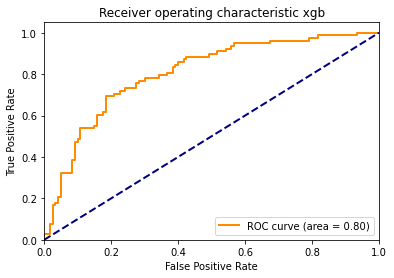

In [29]:
import numpy as np
df_resnet_prob = pd.read_csv('./data/resnet_output_198.csv')

df_xgboost_prob = pd.DataFrame({
    'id': df_feature_test['id'],
    'label': df_feature_test['label'],
    'xgboost_prob': y_test_pred_prob[:,0]
})

df_ensemble = df_xgboost_prob.merge(df_resnet_prob)

prob = df_ensemble['xgboost_prob']*0.5 + df_ensemble['resnet_proba']*0.5
y_test_pred_prob = np.array(list(zip(prob, 1-prob)))
y_test = df_ensemble['label']

get_roc_curve(y_test_pred_prob, y_test)